<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Init" data-toc-modified-id="Init-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Download" data-toc-modified-id="Download-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Download</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluate</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature importance</a></span><ul class="toc-item"><li><span><a href="#Custom" data-toc-modified-id="Custom-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Custom</a></span></li><li><span><a href="#Native" data-toc-modified-id="Native-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Native</a></span></li><li><span><a href="#eli5" data-toc-modified-id="eli5-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>eli5</a></span></li></ul></li><li><span><a href="#Tree" data-toc-modified-id="Tree-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Tree</a></span></li></ul></div>

# Init

In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import eli5

# Download

In [2]:
categories = [
    'alt.atheism',
    'sci.space'
]

train_bunch = fetch_20newsgroups(subset='train', categories=categories)
train_df = pd.DataFrame.from_dict({'text': train_bunch.data, 
                                   'label': train_bunch.target})

test_bunch = fetch_20newsgroups(subset='test', categories=categories)
test_df = pd.DataFrame.from_dict({'text': test_bunch.data, 
                                  'label': test_bunch.target})

test_df.groupby('label').count()

,text
label,
0,319
1,394


# Train

In [3]:
pipeline = Pipeline([
    (
        'vec', 
         FeatureUnion([
             ('TFIDF', TfidfVectorizer(min_df=0.1, max_df=0.5)),
             ('CNT', CountVectorizer())
         ])
    ),
    (
        'clf',
        xgb.XGBClassifier()
    )
])

In [5]:
pipeline.fit(train_df['text'], train_df['label'])

Pipeline(memory=None,
     steps=[('vec', FeatureUnion(n_jobs=1,
       transformer_list=[('TFIDF', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.5, max_features=None, min_df=0.1,
        ngram_r...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

# Evaluate

In [6]:
print accuracy_score(pipeline.predict(train_df['text']), train_df['label'])
print accuracy_score(pipeline.predict(test_df['text']), test_df['label'])

0.992544268406
0.92286115007


# Feature importance

In [7]:
vec = pipeline.named_steps['vec']
clf = pipeline.named_steps['clf']

## Custom

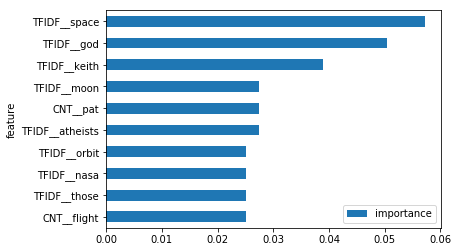

In [8]:
pd.DataFrame.from_dict({
    'feature': vec.get_feature_names(),
    'importance': clf.feature_importances_,
}).sort_values('importance').tail(10).set_index('feature').plot(kind='barh')

## Native

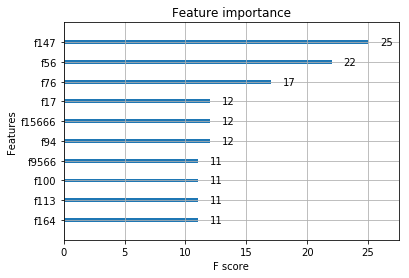

In [9]:
xgb.plot_importance(clf, max_num_features=10)

## eli5

In [9]:
eli5.explain_weights(
    clf.get_booster(),
    vec=vec,
    importance_type='weight',
    top=10
)

Weight,Feature
0.0572,TFIDF__space
0.0503,TFIDF__god
0.0389,TFIDF__keith
0.0275,TFIDF__moon
0.0275,CNT__pat
0.0275,TFIDF__atheists
0.0252,CNT__flight
0.0252,TFIDF__those
0.0252,TFIDF__orbit
0.0252,TFIDF__nasa


# Tree

0:[TFIDF__space<0.0380997] yes=1,no=2,missing=1
	1:[TFIDF__god<0.0203251] yes=3,no=4,missing=3
		3:[TFIDF__atheists<1.29558] yes=7,no=8,missing=8
			7:leaf=-0.192453
			8:leaf=0.0317526
		4:[TFIDF__1993<0.218208] yes=9,no=10,missing=9
			9:leaf=-0.19521
			10:leaf=-0.05
	2:[CNT__god<1.5] yes=5,no=6,missing=5
		5:[CNT__atom<2] yes=11,no=12,missing=12
			11:leaf=-0.05
			12:leaf=0.196215
		6:leaf=-0.12



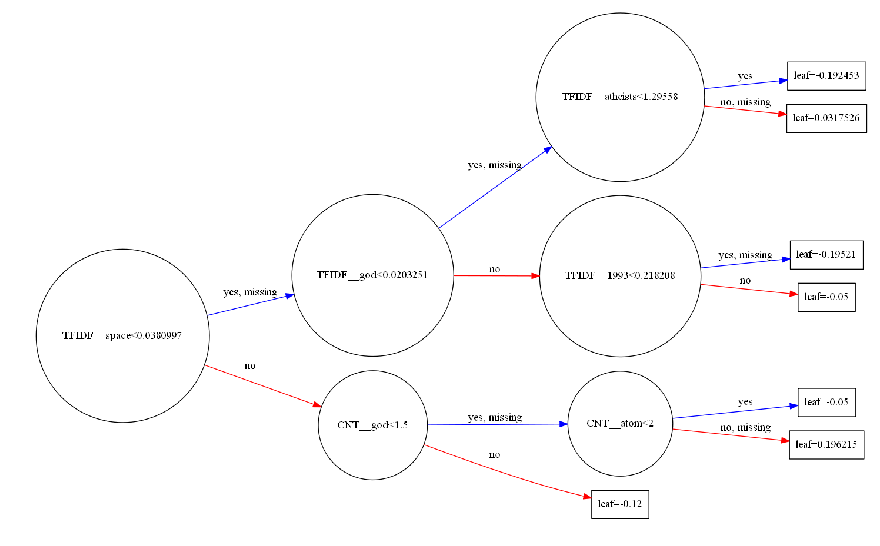

In [12]:
original_feature_names = clf.get_booster().feature_names # save
clf.get_booster().feature_names = vec.get_feature_names()

_, ax = plt.subplots(1, 1, figsize=(15, 25))
xgb.plot_tree(clf, rankdir='LR', ax=ax)
print(clf.get_booster().get_dump()[0])

clf.get_booster().feature_names = original_feature_names # restore